In [ ]:
# What about I compare w2v, glove and BERT encodings on
# SVM, shallow 1 layer NN, which is a fancy way of saying logistic regression, a 2 layer NN (1 hidden layer) which theoretically maps any function and BERT

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from os import close
import numpy as np
import smart_open
import string
import gensim
import gdown
import json
import nltk
import re
import os

In [2]:
# Get Yelp Dataset
fname = '/content/yelp_reviews.json'
if not os.path.isfile(fname) :
  url = 'https://drive.google.com/uc?id=1CisHuncMbBRAaj7yM8aCBLgBqkIcc0Lu'
  output = 'yelp_reviews.json'
  gdown.download(url, output, quiet=False)
else:
  print('Yelp Reviews already there')

Yelp Reviews already there


In [3]:
#string.punctuation
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# Remove punctuations, urls, etc
def clean_text(text):
  # From the last assignment
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word.strip() for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
# Reading N top reviews

filepath = '/content/yelp_reviews.json'
N_target = 5000
N = N_target*10
j = 0

positive = 0
negative = 0

X = []
y = []
with open(filepath) as f:
    for i in range(0, N):
        json_review = json.loads(f.readline())
        if json_review['stars'] == 3:
          continue

        # Label for classification
        if json_review['stars'] in [4,5] and positive <= N_target/2:
            label = 1
            positive += 1
        elif json_review['stars'] in [1,2] and negative <= N_target/2:
            label = -1
            negative += 1
        else:
          continue

        X.append(clean_text(json_review['text']))
        y.append(label)
        j+=1

        if j == N_target:
          break

    f.close()


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Doc2Vec Embedding

In [5]:
def read_corpus(corpus, tokens_only=False):
    for i, line in enumerate(corpus):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [ ]:
train_corpus = list(read_corpus(X_train))
test_corpus = list(read_corpus(X_test, tokens_only=True))
print(len(train_corpus), len(test_corpus))

24000 6000


In [ ]:
embedding_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
embedding_model.build_vocab(train_corpus)
embedding_model.train(train_corpus, total_examples=embedding_model.corpus_count, epochs=embedding_model.epochs)

In [ ]:
def embed_corpus(embedding_model, corpus):
    embeddings = []
    for text in tqdm(corpus, total=len(corpus)):
        tokens = gensim.utils.simple_preprocess(text)
        embeddings.append(embedding_model.infer_vector(tokens))

    return embeddings

In [ ]:
embedded_corpus_train = np.array(embed_corpus(embedding_model, X_train))
embedded_corpus_test = np.array(embed_corpus(embedding_model, X_test))

  0%|          | 0/24000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

SVM

In [21]:
from sklearn import svm

In [47]:
def train_test_display(clf, embedded_corpus_train, y_train, embedded_corpus_test, y_test, model_type):
    clf.fit(embedded_corpus_train, y_train)
    y_preds_train = clf.predict(embedded_corpus_train)
    y_preds_test = clf.predict(embedded_corpus_test)

    accuracy_train = accuracy_score(y_train, y_preds_train)
    accuracy_test = accuracy_score(y_test, y_preds_test)

    confusion_matrix_train = confusion_matrix(y_train, y_preds_train)
    confusion_matrix_test = confusion_matrix(y_test, y_preds_test)

    fig, ax = plt.subplots(1,2, figsize=(15,5))
    cmp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train,display_labels=clf.classes_)
    cmp_train.plot(ax=ax[0])
    ax[0].set_title(f'Training Data \n{model_type} Accuracy: {accuracy_train}', fontsize=20)

    cmp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test,display_labels=clf.classes_)
    cmp_test.plot(ax=ax[1])
    ax[1].set_title(f'Testing Data \n{model_type} Accuracy: {accuracy_test}', fontsize=20)

    plt.show()

    return y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test


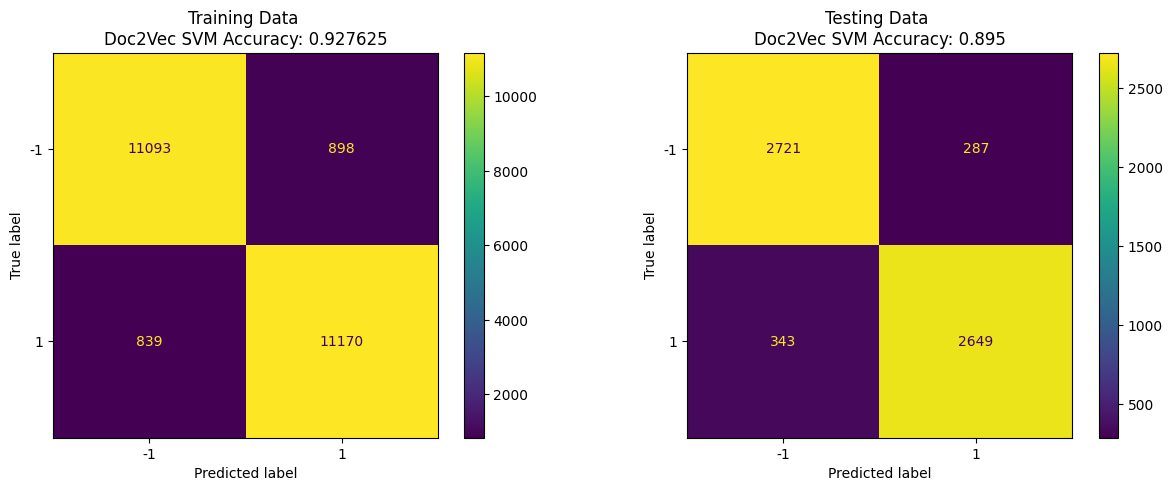

In [ ]:
# Create model and fit using training embeddings
clf = svm.SVC()
y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = train_test_display(clf, embedded_corpus_train, y_train, embedded_corpus_test, y_test,'Doc2Vec SVM')

Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

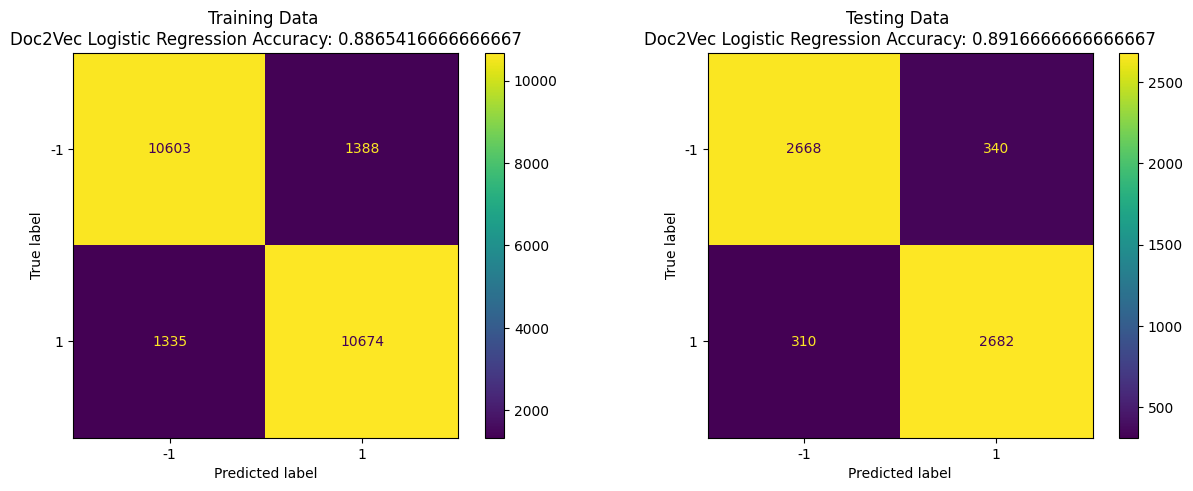

In [ ]:
clf = LogisticRegression(random_state=0)
y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = train_test_display(clf, embedded_corpus_train, y_train, embedded_corpus_test, y_test,'Doc2Vec Logistic Regression')

Single layer NN

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Sequential, Module
from sklearn.metrics import precision_score, recall_score

In [12]:
class Single_Layer_NN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, X):
        logits = self.seq(X)
        return logits


class Two_Layers_NN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, X):
        logits = self.seq(X)
        return logits

In [17]:
def embedding_dataloader(embedded_corpus, labels, batch_size):
    to_load = []
    for i in range(len(embedded_corpus)):
      # convert label -1 to 0
      label = max(labels[i],0)
      to_load.append([embedded_corpus[i], label])

    return DataLoader(to_load, batch_size = batch_size)

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer, t, print_log=True):
    size = len(dataloader.dataset)
    correct = 0
    training_acc = 0
    training_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.type(torch.float32).to(device))
        loss = loss_fn(pred, y.type(torch.LongTensor).to(device))
        correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss, current = loss.item(), batch * len(X)
        training_loss = loss
        #if (print_log==True) and (batch % 100 == 0):
        #    print(f"""Training loop: loss: {loss:>7f}  [{current:>5d}/{size:>5d}]""")
    correct /= size
    training_acc = 100*correct
    if print_log==True and (t+1)%10==0:
        print(f"""Training Accuracy: {training_acc:>0.1f}%""")
    return training_acc, training_loss

In [14]:
def test_loop(dataloader, model, loss_fn, t, print_log=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.type(torch.float32).to(device))
            test_loss += loss_fn(pred, y.type(torch.LongTensor).to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    testing_acc = 100*correct
    if print_log==True and (t+1)%10==0:
        print(f"Testing Accuracy: {testing_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return testing_acc, test_loss

In [15]:
def nn_model_display(model, train_dataloader, test_dataloader, model_type):

    X_preds_train = []
    y_train = []
    with torch.no_grad():
        for X, y in train_dataloader:
            X_preds_train.append(model(X.type(torch.float32).to(device)))
            y_train.append(y)

    y_train = torch.flatten(torch.stack(y_train))

    X_preds_test = []
    y_test = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X_preds_test.append(model(X.type(torch.float32).to(device)))
            y_test.append(y)

    y_test = torch.flatten(torch.stack(y_test))

    y_preds_train = torch.flatten(torch.stack(X_preds_train).argmax(2))
    y_preds_test = torch.flatten(torch.stack(X_preds_test).argmax(2))

    accuracy_train = accuracy_score(y_train, y_preds_train.cpu())
    accuracy_test = accuracy_score(y_test, y_preds_test.cpu())

    confusion_matrix_train = confusion_matrix(y_train, y_preds_train.cpu())
    confusion_matrix_test = confusion_matrix(y_test, y_preds_test.cpu())

    fig, ax = plt.subplots(1,2, figsize=(15,5))
    cmp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train,display_labels=(-1,1))
    cmp_train.plot(ax=ax[0])
    ax[0].set_title(f'{model_type}\nTraining Data \nAccuracy: {accuracy_train}')

    cmp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test,display_labels=(-1,1))
    cmp_test.plot(ax=ax[1])
    ax[1].set_title(f'{model_type}\nTesting Data \nAccuracy: {accuracy_test}')

    plt.show()

    return y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test


Using cuda device
Epoch 10
-------------------------------
Training Accuracy: 90.2%
Testing Accuracy: 89.3%, Avg loss: 0.256885 

Epoch 20
-------------------------------
Training Accuracy: 90.9%
Testing Accuracy: 89.1%, Avg loss: 0.263647 

Epoch 30
-------------------------------
Training Accuracy: 91.3%
Testing Accuracy: 89.1%, Avg loss: 0.270302 

Epoch 40
-------------------------------
Training Accuracy: 91.5%
Testing Accuracy: 88.8%, Avg loss: 0.275467 

Epoch 50
-------------------------------
Training Accuracy: 91.7%
Testing Accuracy: 88.5%, Avg loss: 0.279097 

Epoch 60
-------------------------------
Training Accuracy: 92.0%
Testing Accuracy: 88.6%, Avg loss: 0.282468 

Epoch 70
-------------------------------
Training Accuracy: 92.1%
Testing Accuracy: 88.3%, Avg loss: 0.285691 

Epoch 80
-------------------------------
Training Accuracy: 92.2%
Testing Accuracy: 88.4%, Avg loss: 0.287797 

Epoch 90
-------------------------------
Training Accuracy: 92.3%
Testing Accuracy: 88

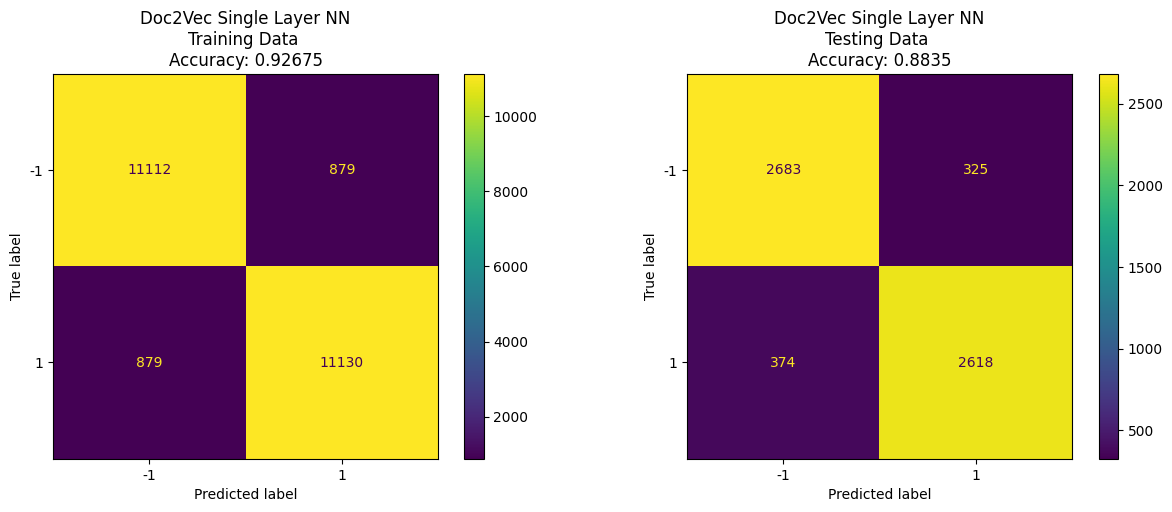

In [ ]:
input_dim = embedded_corpus_train.shape[1]
hidden_dim = input_dim*2
output_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_1_layer = Single_Layer_NN(input_dim, hidden_dim, output_dim).to(device)
model_1_layer.requires_grad_(True)

learning_rate = 1e-3
batch_size = 100
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1_layer.parameters(), lr=learning_rate, weight_decay=1e-3)

train_dataloader = embedding_dataloader(embedded_corpus_train, y_train, batch_size)
test_dataloader = embedding_dataloader(embedded_corpus_test, y_test, batch_size)

train_acc, train_loss = [], []
test_acc, test_loss = [], []

for t in range(epochs):
    if (t+1)%10 == 0:
      print(f"Epoch {t+1}\n-------------------------------")
    acc, loss = train_loop(train_dataloader, model_1_layer, loss_fn, optimizer, t)
    train_acc.append(acc)
    train_loss.append(loss)
    acc, loss = test_loop(test_dataloader, model_1_layer, loss_fn, t)
    test_acc.append(acc)
    test_loss.append(loss)
print("Done!")

y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = nn_model_display(model_1_layer, train_dataloader, test_dataloader, 'Doc2Vec Single Layer NN')

2 Layers NN

Epoch 10
-------------------------------
Training Accuracy: 90.6%
Testing Accuracy: 88.8%, Avg loss: 0.262922 

Epoch 20
-------------------------------
Training Accuracy: 91.8%
Testing Accuracy: 88.4%, Avg loss: 0.282567 

Epoch 30
-------------------------------
Training Accuracy: 92.6%
Testing Accuracy: 88.2%, Avg loss: 0.298496 

Epoch 40
-------------------------------
Training Accuracy: 93.3%
Testing Accuracy: 87.7%, Avg loss: 0.318073 

Done!


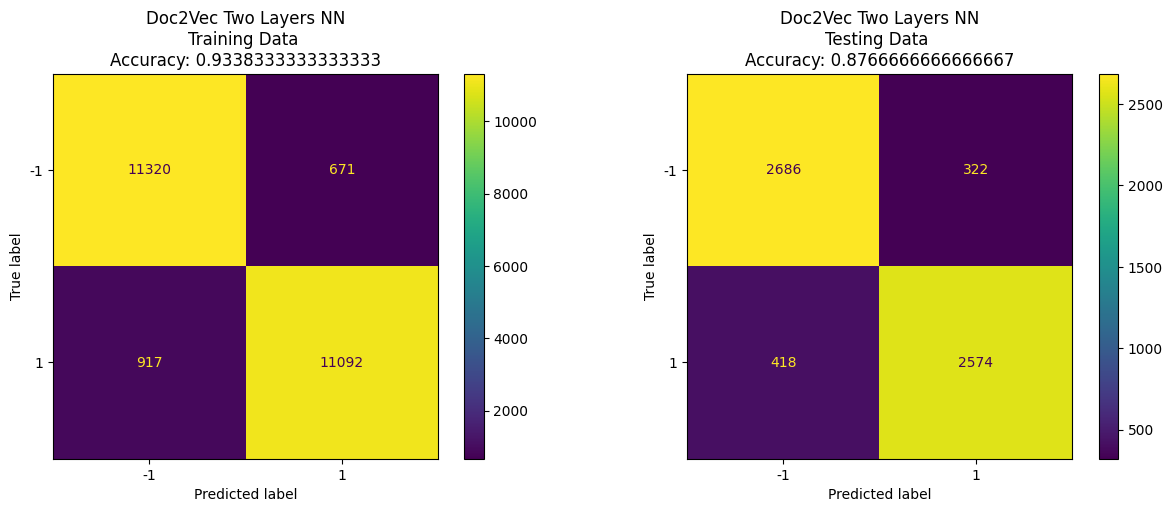

In [ ]:
model_2_layer = Two_Layers_NN(input_dim, hidden_dim, output_dim).to(device)
model_2_layer.requires_grad_(True)

learning_rate = 1e-3
batch_size = 100
epochs = 40
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2_layer.parameters(), lr=learning_rate, weight_decay=1e-3)

train_acc, train_loss = [], []
test_acc, test_loss = [], []

for t in range(epochs):
    if (t+1)%10 == 0:
      print(f"Epoch {t+1}\n-------------------------------")
    acc, loss = train_loop(train_dataloader, model_2_layer, loss_fn, optimizer, t)
    train_acc.append(acc)
    train_loss.append(loss)
    acc, loss = test_loop(test_dataloader, model_2_layer, loss_fn, t)
    test_acc.append(acc)
    test_loss.append(loss)
print("Done!")

y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = nn_model_display(model_2_layer, train_dataloader, test_dataloader, 'Doc2Vec Two Layers NN')

Glove Embeddings

In [ ]:
!pip install glove-python3

In [ ]:
from glove import Corpus, Glove
# creating a corpus object
glove_train_corpus = [i.words for i in train_corpus]
glove_test_corpus = test_corpus.copy()
corpus = Corpus()
corpus.fit(glove_train_corpus, window=10)

In [ ]:
glove = Glove(no_components=50, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [ ]:
glove.add_dictionary(corpus.dictionary)

In [ ]:
def glove_embbedding_mean(text, glove, no_components):
  embedding = np.zeros(no_components)

  for word in text:
    try:
      embedding += glove.word_vectors[glove.dictionary[word]]
    # If word not in vocabulary pass 0 array
    except:
      embedding += np.zeros(no_components)

  embedding_mean = embedding/no_components

  return embedding_mean


In [ ]:
embedded_corpus_train = np.array([glove_embbedding_mean(i, glove, 50) for i in glove_train_corpus])
embedded_corpus_test = np.array([glove_embbedding_mean(i, glove, 50) for i in glove_test_corpus])

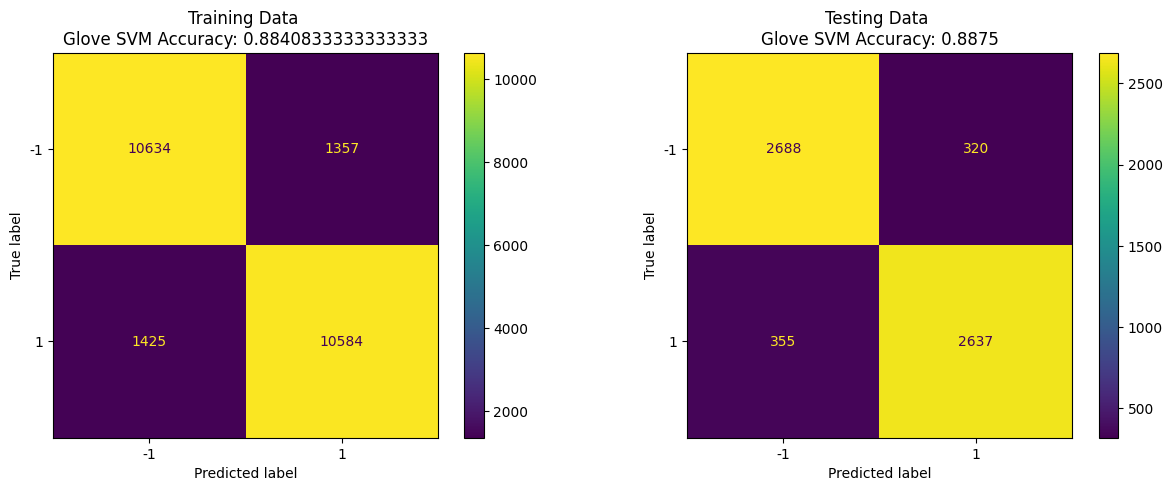

In [ ]:
clf = svm.SVC()
y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = train_test_display(clf, embedded_corpus_train, y_train, embedded_corpus_test, y_test,'Glove SVM')

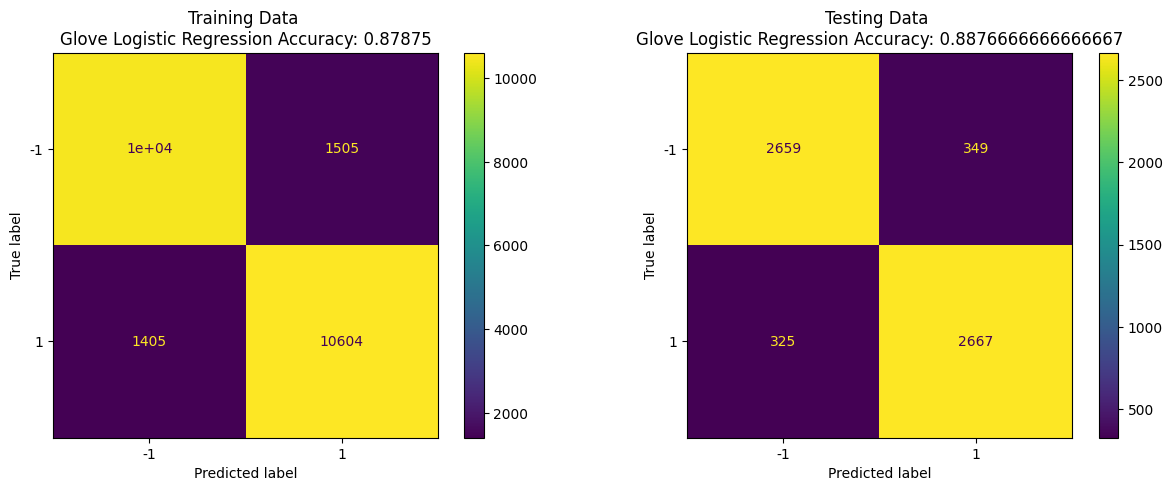

In [ ]:
clf = LogisticRegression(random_state=0)
y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = train_test_display(clf, embedded_corpus_train, y_train, embedded_corpus_test, y_test,'Glove Logistic Regression')

In [ ]:
train_dataloader = embedding_dataloader(embedded_corpus_train, y_train, batch_size)
test_dataloader = embedding_dataloader(embedded_corpus_test, y_test, batch_size)

Using cuda device
Epoch 10
-------------------------------
Training Accuracy: 87.6%
Testing Accuracy: 88.4%, Avg loss: 0.290904 

Epoch 20
-------------------------------
Training Accuracy: 87.7%
Testing Accuracy: 88.5%, Avg loss: 0.286266 

Epoch 30
-------------------------------
Training Accuracy: 87.9%
Testing Accuracy: 88.6%, Avg loss: 0.284568 

Epoch 40
-------------------------------
Training Accuracy: 87.9%
Testing Accuracy: 88.5%, Avg loss: 0.283352 

Done!


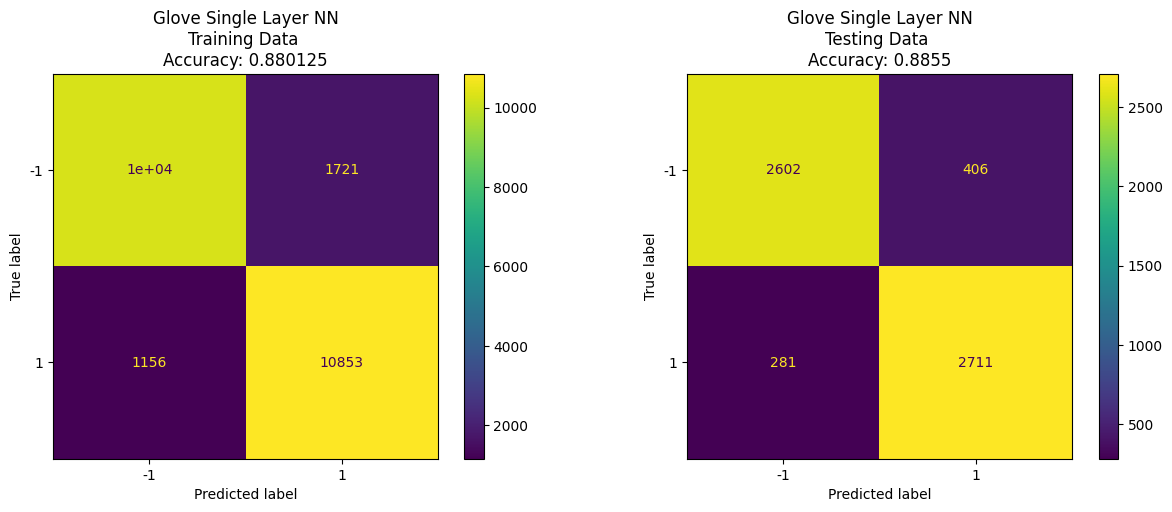

In [ ]:
input_dim = embedded_corpus_train.shape[1]
hidden_dim = input_dim*2
output_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_1_layer = Single_Layer_NN(input_dim, hidden_dim, output_dim).to(device)
model_1_layer.requires_grad_(True)

learning_rate = 1e-3
batch_size = 100
epochs = 40
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1_layer.parameters(), lr=learning_rate, weight_decay=1e-3)


train_acc, train_loss = [], []
test_acc, test_loss = [], []

for t in range(epochs):
    if (t+1)%10 == 0:
      print(f"Epoch {t+1}\n-------------------------------")
    acc, loss = train_loop(train_dataloader, model_1_layer, loss_fn, optimizer, t)
    train_acc.append(acc)
    train_loss.append(loss)
    acc, loss = test_loop(test_dataloader, model_1_layer, loss_fn, t)
    test_acc.append(acc)
    test_loss.append(loss)
print("Done!")

y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = nn_model_display(model_1_layer, train_dataloader, test_dataloader, 'Glove Single Layer NN')

Epoch 10
-------------------------------
Training Accuracy: 87.7%
Testing Accuracy: 88.4%, Avg loss: 0.284004 

Epoch 20
-------------------------------
Training Accuracy: 88.2%
Testing Accuracy: 88.6%, Avg loss: 0.274991 

Epoch 30
-------------------------------
Training Accuracy: 88.5%
Testing Accuracy: 89.0%, Avg loss: 0.269153 

Epoch 40
-------------------------------
Training Accuracy: 88.6%
Testing Accuracy: 88.9%, Avg loss: 0.267794 

Done!


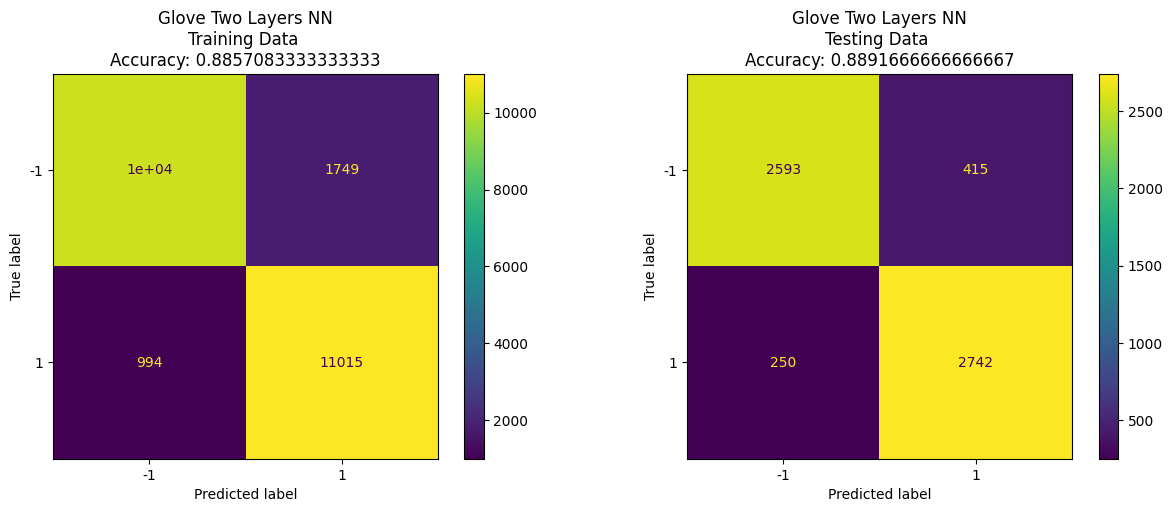

In [ ]:
model_2_layer = Two_Layers_NN(input_dim, hidden_dim, output_dim).to(device)
model_2_layer.requires_grad_(True)

learning_rate = 1e-3
batch_size = 100
epochs = 40
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2_layer.parameters(), lr=learning_rate, weight_decay=1e-3)

train_acc, train_loss = [], []
test_acc, test_loss = [], []

for t in range(epochs):
    if (t+1)%10 == 0:
      print(f"Epoch {t+1}\n-------------------------------")
    acc, loss = train_loop(train_dataloader, model_2_layer, loss_fn, optimizer, t)
    train_acc.append(acc)
    train_loss.append(loss)
    acc, loss = test_loop(test_dataloader, model_2_layer, loss_fn, t)
    test_acc.append(acc)
    test_loss.append(loss)
print("Done!")

y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = nn_model_display(model_2_layer, train_dataloader, test_dataloader, 'Glove Two Layers NN')

BERT Tokenizer

In [6]:
from transformers import AutoTokenizer, DistilBertModel
import torch

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [38]:
embedded_corpus_train = torch.zeros(len(X_train),768)
for i in tqdm(range(len(X_train)), total=len(X_train)):
  with torch.no_grad():
    inputs = tokenizer(X_train[i], return_tensors="pt", padding=True, truncation=True, max_length=42)
    outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    sentence_embedding = torch.mean(last_hidden_states.squeeze(),0)
    embedded_corpus_train[i] = sentence_embedding

  0%|          | 0/4000 [00:00<?, ?it/s]

In [39]:
embedded_corpus_test = torch.zeros(len(X_test),768)
for i in tqdm(range(len(X_test)), total=len(X_test)):
  with torch.no_grad():
    inputs = tokenizer(X_test[i], return_tensors="pt", padding=True, truncation=True, max_length=42)
    outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    sentence_embedding = torch.mean(last_hidden_states.squeeze(),0)
    embedded_corpus_test[i] = sentence_embedding

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
batch_size = 100
train_dataloader = embedding_dataloader(embedded_corpus_train, y_train, batch_size)
test_dataloader = embedding_dataloader(embedded_corpus_test, y_test, batch_size)

In [41]:
for i in range(len(embedded_corpus_train)):
 if embedded_corpus_train[i].shape[0] != 768:
  print(i, embedded_corpus_train[i].shape[0])

In [42]:
type(embedded_corpus_train)

torch.Tensor

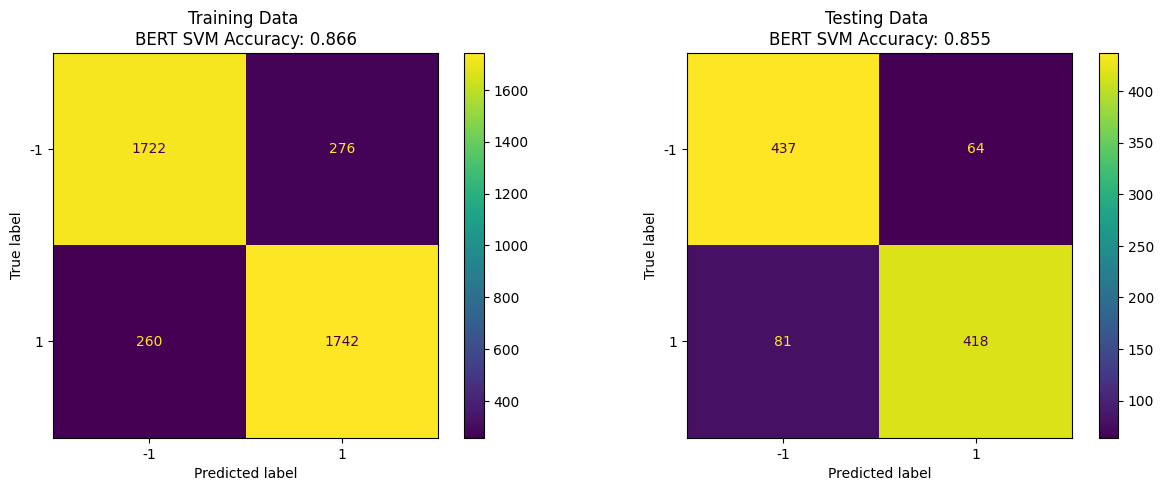

In [43]:
clf = svm.SVC()
y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = train_test_display(clf, embedded_corpus_train, y_train, embedded_corpus_test, y_test,'BERT SVM')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


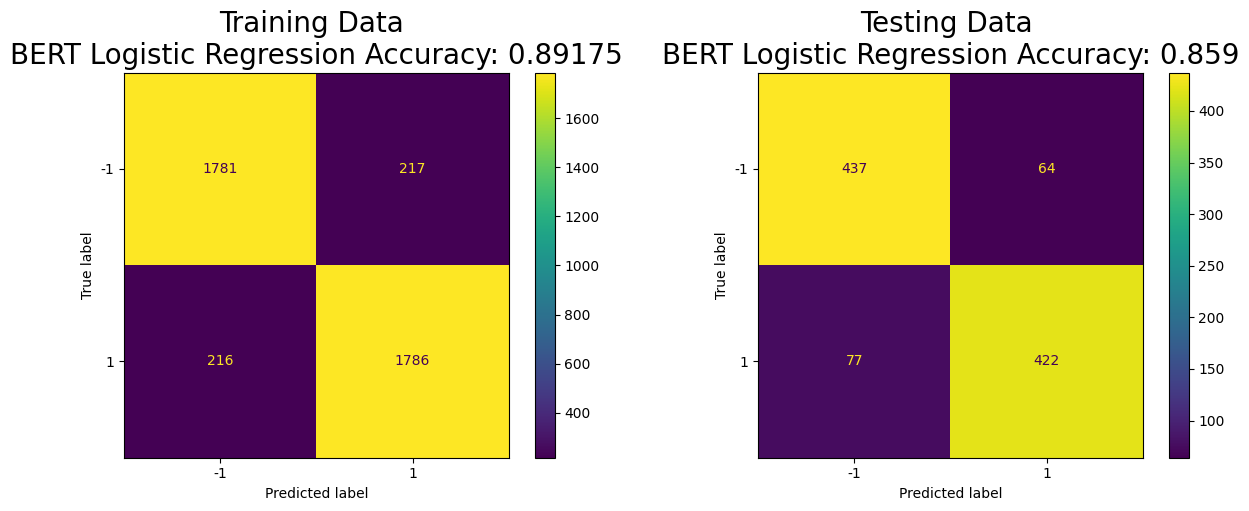

In [48]:
clf = LogisticRegression(random_state=0)
y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = train_test_display(clf, embedded_corpus_train, y_train, embedded_corpus_test, y_test,'BERT Logistic Regression')

Using cuda device
Epoch 10
-------------------------------
Training Accuracy: 85.8%
Testing Accuracy: 84.1%, Avg loss: 0.359258 

Epoch 20
-------------------------------
Training Accuracy: 87.2%
Testing Accuracy: 84.6%, Avg loss: 0.352039 

Epoch 30
-------------------------------
Training Accuracy: 89.0%
Testing Accuracy: 84.2%, Avg loss: 0.354734 

Epoch 40
-------------------------------
Training Accuracy: 91.8%
Testing Accuracy: 82.4%, Avg loss: 0.420633 

Epoch 50
-------------------------------
Training Accuracy: 92.3%
Testing Accuracy: 79.0%, Avg loss: 0.552115 

Epoch 60
-------------------------------
Training Accuracy: 90.6%
Testing Accuracy: 82.3%, Avg loss: 0.425233 

Epoch 70
-------------------------------
Training Accuracy: 96.0%
Testing Accuracy: 84.2%, Avg loss: 0.389978 

Epoch 80
-------------------------------
Training Accuracy: 98.1%
Testing Accuracy: 84.0%, Avg loss: 0.401892 

Epoch 90
-------------------------------
Training Accuracy: 98.5%
Testing Accuracy: 84

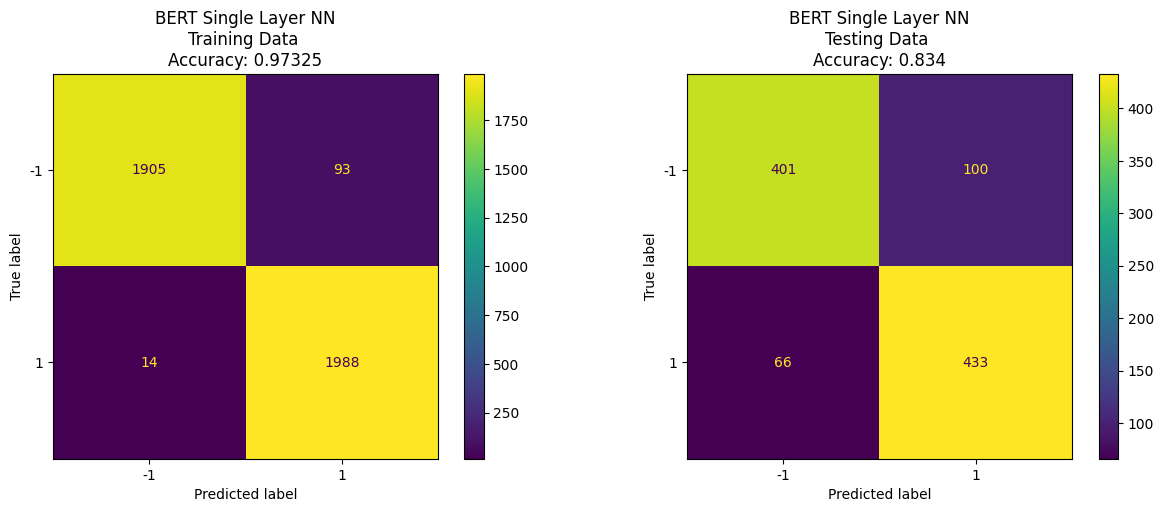

In [45]:
input_dim = embedded_corpus_train.shape[1]
hidden_dim = input_dim*2
output_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_1_layer = Single_Layer_NN(input_dim, hidden_dim, output_dim).to(device)
model_1_layer.requires_grad_(True)

learning_rate = 1e-3
batch_size = 100
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1_layer.parameters(), lr=learning_rate, weight_decay=1e-3)


train_acc, train_loss = [], []
test_acc, test_loss = [], []

for t in range(epochs):
    if (t+1)%10 == 0:
      print(f"Epoch {t+1}\n-------------------------------")
    acc, loss = train_loop(train_dataloader, model_1_layer, loss_fn, optimizer, t)
    train_acc.append(acc)
    train_loss.append(loss)
    acc, loss = test_loop(test_dataloader, model_1_layer, loss_fn, t)
    test_acc.append(acc)
    test_loss.append(loss)
print("Done!")

y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = nn_model_display(model_1_layer, train_dataloader, test_dataloader, 'BERT Single Layer NN')

Epoch 10
-------------------------------
Training Accuracy: 88.2%
Testing Accuracy: 83.5%, Avg loss: 0.384486 

Epoch 20
-------------------------------
Training Accuracy: 90.5%
Testing Accuracy: 80.6%, Avg loss: 0.572272 

Epoch 30
-------------------------------
Training Accuracy: 93.2%
Testing Accuracy: 81.7%, Avg loss: 0.459434 

Epoch 40
-------------------------------
Training Accuracy: 94.1%
Testing Accuracy: 82.5%, Avg loss: 0.571345 

Done!


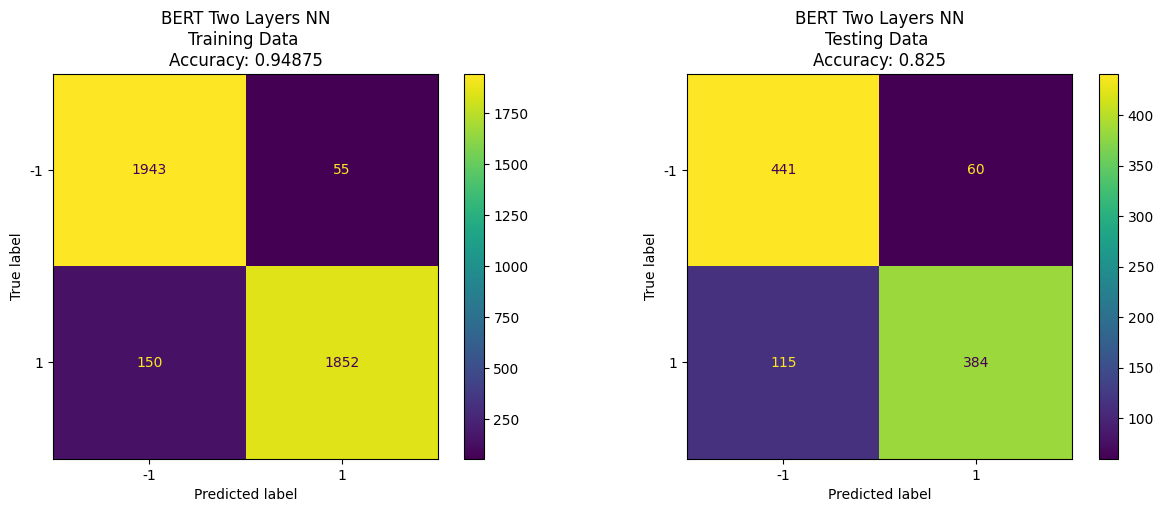

In [46]:
model_2_layer = Two_Layers_NN(input_dim, hidden_dim, output_dim).to(device)
model_2_layer.requires_grad_(True)

learning_rate = 1e-3
batch_size = 100
epochs = 40
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2_layer.parameters(), lr=learning_rate, weight_decay=1e-3)

train_acc, train_loss = [], []
test_acc, test_loss = [], []

for t in range(epochs):
    if (t+1)%10 == 0:
      print(f"Epoch {t+1}\n-------------------------------")
    acc, loss = train_loop(train_dataloader, model_2_layer, loss_fn, optimizer, t)
    train_acc.append(acc)
    train_loss.append(loss)
    acc, loss = test_loop(test_dataloader, model_2_layer, loss_fn, t)
    test_acc.append(acc)
    test_loss.append(loss)
print("Done!")

y_preds_train, y_preds_test, accuracy_train, accuracy_test, confusion_matrix_train, confusion_matrix_test = nn_model_display(model_2_layer, train_dataloader, test_dataloader, 'BERT Two Layers NN')